# Loading Dependencies

In [3]:
#import pycromanager 
from pycromanager import Core, Acquisition, multi_d_acquisition_events, Dataset
from matplotlib.pyplot import * 
import numpy as np
from PIL import Image
from scipy.ndimage import maximum_filter
import random

In [5]:
core = Core()

In [9]:
loaded_devices = core.get_loaded_devices()

In [12]:
loaded_devices.size

'OSc-LSM'

In [ ]:
core.get_pixel_size_um()

In [6]:
core.snap_image()

In [13]:
def name_loaded_devices(loaded_devices):
    return [loaded_devices.get(i) for i in range(loaded_devices.size())]

In [17]:
loaded_devices_names = name_loaded_devices(loaded_devices)

In [18]:
for device_name in loaded_devices_names:
    device_prop = core.get_device_property_names(device_name)
    print(device_name,"\n",name_loaded_devices(device_prop),"\n-----\n")
    

COM4 
 ['AnswerTimeout', 'BaudRate', 'DTR', 'DataBits', 'DelayBetweenCharsMs', 'Description', 'Fast USB to Serial', 'Handshaking', 'Name', 'Parity', 'StopBits', 'Verbose'] 
-----

OScHub 
 [] 
-----

OSc-LSM 
 ['BH-TCSPC-CheckSyncBeforeAcquisition', 'BH-TCSPC-EnableChannel0', 'BH-TCSPC-EnableChannel1', 'BH-TCSPC-EnableChannel10', 'BH-TCSPC-EnableChannel11', 'BH-TCSPC-EnableChannel12', 'BH-TCSPC-EnableChannel13', 'BH-TCSPC-EnableChannel14', 'BH-TCSPC-EnableChannel15', 'BH-TCSPC-EnableChannel2', 'BH-TCSPC-EnableChannel3', 'BH-TCSPC-EnableChannel4', 'BH-TCSPC-EnableChannel5', 'BH-TCSPC-EnableChannel6', 'BH-TCSPC-EnableChannel7', 'BH-TCSPC-EnableChannel8', 'BH-TCSPC-EnableChannel9', 'BH-TCSPC-FLIMFileNamePrefix', 'BH-TCSPC-FrameMarker', 'BH-TCSPC-IntensityImagesAreCumulative', 'BH-TCSPC-LineDelay_px', 'BH-TCSPC-LineMarker', 'BH-TCSPC-Marker0ActiveEdge', 'BH-TCSPC-Marker1ActiveEdge', 'BH-TCSPC-Marker2ActiveEdge', 'BH-TCSPC-Marker3ActiveEdge', 'BH-TCSPC-PixelMappingMode', 'BH-TCSPC-PixelMark

# Functions

In [1]:
def center_grid(x, y) :
    """Create 3x3 grid centered on x,y with d distance to other squares

        Parameters:
        x (int): x coordinate
        y (int): y coordinate
        d (int): distance of squares from center

        Returns:
        ndarray: 3x3 grid
    """
    #core.get_property('OSc-LSM', 'LSM-Resolution')
    pixel_d = int(core.get_property('Camera','OnCameraCCDYSize'))
    scale =core.get_pixel_size_um()
    d = pixel_d*scale
    
    return np.array([[x-d,y-d], [x,y-d], [x+d,y-d],
                     [x-d,y], [x,y], [x+d,y],
                     [x-d,y+d], [x,y+d], [x+d,y+d]])


In [253]:
def acq_images(filename, directory, xy_coords):
    """Acquire 3x3 grid of images centered around x,y

        Parameters:
        filename (str): file name
        directory (str): directory path to file
        xy_coords (ndarray): 3x3 grid of coordinates to acquire pictures of

        Returns:
        NDTiffDataset: dataset of acq images
    """
    
    with Acquisition(directory=directory, 
                        name=filename) as acq:
        events = multi_d_acquisition_events(xy_positions=xy_coords)
        acq.acquire(events)  
                            
        return acq.get_dataset()

In [252]:
def images_list(dataset):
    """Create a list of images from dataset

        Parameters:
        dataset (NDTiffDataset): a dataset of acq images

        Returns:
        list: list of images
    """
    
    ax = dataset.axes
    amount = ax["position"]

    im_list = []
    for i in amount:
        im_list.append(Image.fromarray(dataset.read_image(position=i)))
    
    return im_list
        

In [262]:
def stitch_images(lst, n, m):
    """Create a mosaic of images in an nxm grid

        Parameters:
        lst (list): list of images
        n (int): n rows
        m (int): m cols

        Returns:
        Image: nxm grid of images
    """
    
    sizing = lst[0].size
    mod = lst[0].mode
    #nxwidth of image, mxheight of images
    new_image = Image.new(mode=mod, size=(n*sizing[0], m*sizing[1]))

    iter=0
    for i in range(m):
        for j in range(n):
            #coord are (x,y)
            new_image.paste(lst[iter], (j*sizing[0], i*sizing[1]))
            iter+=1
    return new_image

In [263]:
def get_2dmaxima(image,kernelsize=3):
    """Get maximas of image

        Parameters:
        image (Image): image to get maximas of
        kernelsize (int): size of filter used to find maximas

        Returns:
        ndarray: maximas of image
    """
    # convert image to array
    image_array= np.array(image)
    
    return image_array == maximum_filter(image_array, footprint=np.ones((kernelsize,kernelsize)))

In [264]:
def get_coord_maxima(image):
    """Get coordinates of maximas

        Parameters:
        image (Image): maximas image

        Returns: list of maxima coordinates
        
    """
    #convert image to array
    image_array= np.array(image)
    
    index = np.where(image_array!= 0)
    coord = list(zip(index[0], index[1]))
    return coord

In [ ]:
def offset(list):
    #stage coord = imCoord * a + b
    #a = um per pixel, b = x (or y) - total pix *um per pix
    
    #pixel size in total
    pix = int(core.get_property('Camera', 'OnCameraCCDXSize'))
    
    #um / pixel
    scale =core.get_pixel_size_um()
    
    um = pix*scale
    
    #in actual implementation would be coord from orig input to grid-coord-maker
    x_origin = core.get_x_position()
    y_origin = core.get_y_position()
    
    new_list = []
    
    for i in list:
        new_x = i[0] * scale + (x_origin-um)
        new_y = i[1] * scale + (y_origin-um)
        new_list.append((new_x,new_y))
    
    return new_list
        
    

In [272]:
def acq_maxima(x,y, fname,dirpath, show_im=True):
    """Acquire images and get maximas

        Parameters:
        x (int): x coordinate to center grid on
        y (int): y coordinate to center grid on
        d (int): distance from center to squares of grid
        fname (str): name of file saving images to 
        dirpath (str): path to file
        show_im (bool): Optional, show images of mosaic and local maximas 

        Returns:
        imgs_max (ndarray): local maximas of mosaic
        coord (list): coordinates of local maximas
        stitched_im (ndarray): mosaic of acq images
        d (int): distance between squares of grid (used for zoom function)
        size (tuple of ints): size of image (used for zoom function)
        
    """
    xy = center_grid(x,y)

    #acq imagaes
    dataset = acq_images(fname,dirpath,xy)
    im_lst = images_list(dataset)

    #stitch images
    stitch_im = stitch_images(im_lst,3,3)
    stitched_im= np.array(stitch_im)


    #get maxima
    imgs_max = get_2dmaxima(stitched_im)
    
    #get maxima's coords
    coord = get_coord_maxima(imgs_max)
    #translate to from local pixel to global um
    for 

    if show_im:
        imshow(stitched_im)
        figure(), imshow(imgs_max)

    #size info
    size = stitched_im.shape
    
    return imgs_max,coord,stitched_im, size

In [ ]:
def zoom2(coord):
    

In [273]:
def zoom(x,y,d_old, size_old, q, fname,dirpath):
    """Acquire images and get maximas around a chosen local maxima

        Parameters:
        x (int): x coordinate of chosen local maxima to center grid on
        y (int): y coordinate of chosen local maxima to center grid on
        d_old (int): distance btwn squares of grid used in previous iterations
        size_old (tuple of ints): size of graph on image used in previous iterations
        q (int): factor sizing down by
        fname (str): name of file saving images to 
        dirpath (str): path to file
         

        Returns:
        imgs_max (ndarray): local maximas of mosaic
        coord (list): coordinates of local maximas
        stitched_im (ndarray): mosaic of acq images
        d_new (int): distance between squares of grid around local maxima (used for zoom function)
        size_new (tuple of ints): new size of graph on image (used for zoom function)
        
    """
    
    #new xy, coord from prev / size of image from prev
    x_spec,y_spec = x/size_old[0],y/size_old[1]
    d_new = d_old/q

    imgs_max,coord,stitched_im, d_new, size_irr= acq_maxima(x_spec,y_spec,d_new, fname,dirpath, show_im=False)
    
    
    size_new = [(size_old[0]/q), (size_old[1]/q)]

    #show stitched and maxima images (resized)
    figure(), imshow(stitched_im, extent=[0,size_new[0], size_new[1],0])
    figure(), imshow(imgs_max, extent=[0,size_new[0], size_new[1],0])

    return imgs_max,coord,stitched_im, d_new,size_new
    

# tests

In [243]:
fname= 'xy_tile_try28'
dirpath = r"C:\Users\lociu\Desktop\PriyaM\Data\image_collection"

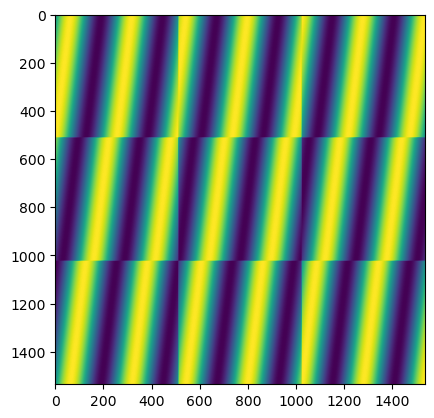

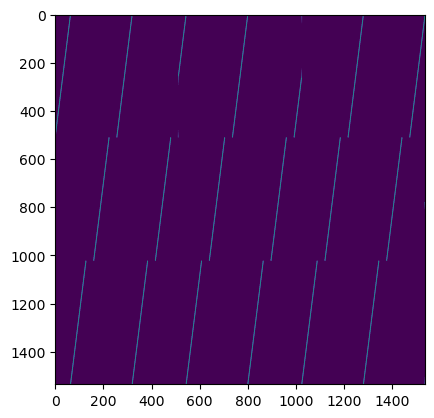

In [274]:
#acq_maxima
imgs_max,coord,stitched_im,d,size = acq_maxima(2,2,1,fname,dirpath)

In [275]:
#random local maxima
x,y = random.choice(coord)

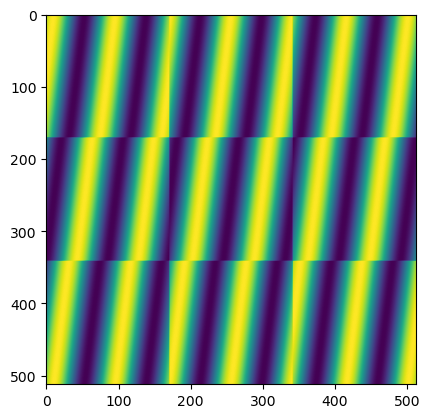

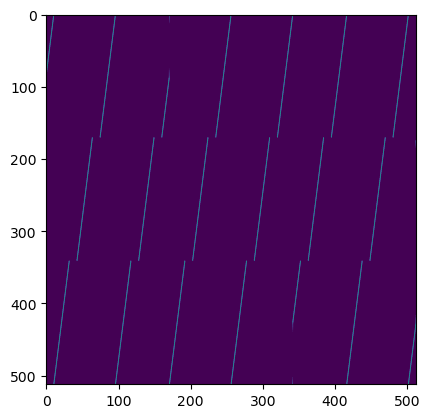

In [276]:
#zoom
imgs_max_2,coord_2,stitched_im_2,d_2,size_2 = zoom(x,y,d, size, 3, fname,dirpath)

In [277]:
#random local maxima
x_2,y_2 = random.choice(coord)

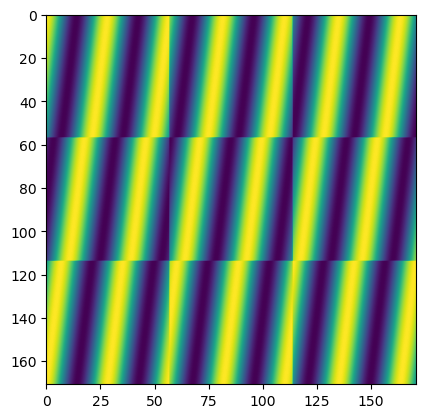

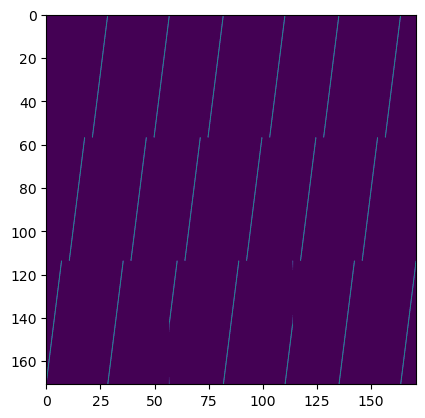

In [278]:
#zoom
imgs_max_3,coord_3,stitched_im_3,d_3,size_3 = zoom(x_2,y_2,d_2, size_2, 3, fname,dirpath)